## Visualizing and identifying loci out of Hardy Weinberg Equilibrium

**20191022** NL

This notebook runs HWE tests in Genepop through R, then parses the output. It then plots the number of populations in which a locus is out of HWE. Using this plot, you can determine how you want to filter for HWE. Specifically, you can set the alpha to use after the FDR correction, and the number of populations that a locus must be out of HWE to be filtered out.

In [3]:
import sys
import os
import subprocess as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.stats.multitest as multitest

#### **[1]** Name inputs

In [4]:
gp_directory = "/mnt/hgfs/E/dDocent_for_mox/parcal_wd/parcal_mox001/"
alpha = 0.05 # threshold for considering a q value significant
xpops = 2 # if out of HWE using FDR approach in x pops or more, filter out
gp_filename = "primSNPs_noINDL_parcal_mox001_md70_maf05_minQ20_mDP10_inames_noreps.txt"
corename = "primSNPs_noINDL_parcal_mox001_md70_maf05_minQ20_mDP10_inames_noreps"

#### **[2]** Call Genepop to run Hardy Weinberg tests

In [9]:
# call R to run genepop to get HWE p values
os.chdir(gp_directory)
HWE_out_filename = corename + "_HWE_out.txt"
call_R_string = "Rscript " + "runGP_for_HWE.R " 
call_R_string += gp_filename
call_R_string += " " + HWE_out_filename
print(call_R_string)
sp.call([call_R_string],shell=True)

Rscript runGP_for_HWE.R primSNPs_noINDL_parcal_mox001_md70_maf05_minQ20_mDP10_inames_noreps.txt primSNPs_noINDL_parcal_mox001_md70_maf05_minQ20_mDP10_inames_noreps_HWE_out.txt


0

In [11]:
cd 

/mnt/hgfs/E/dDocent_batches_noCA/all_batches_filtering/dp10/primSNPs_noINDL_6batches_mac5_mQ20_mDP10_inames_noreps_md30locus_nopertest_GPsumfiles


#### **[3]** Parse output of Hardy Weinberg tests

In [10]:
# get relevant portion of HWE output file for parsing
HWE_file = open(HWE_out_filename, "r")
HWE_file_text = HWE_file.read()
HWE_file_text_noheader = HWE_file_text.split("Results by")[1]
HWE_file_lines = HWE_file_text_noheader.split("\n")

# iterate through lines and feed dictionary, with key locus and value a list of Pvalues for each population
pval_dict = {}
popnames = [] 
header_count = 2 
last_locus = "" 
ordered_loci = []
for line in HWE_file_lines:
    if line.startswith("Locus ") and header_count == 2:
        header_count = 0
        linelist = line.strip().split()
        locus_name = linelist[1].replace('"','')
        last_locus = locus_name
        pval_dict[locus_name] = []
        ordered_loci.append(locus_name)
    elif header_count == 2 and len(line.strip().split()) > 1 and line.startswith("All") == False and line.startswith(" ") == False:
        linelist = line.strip().split()
        popname = linelist[0]
        if popname not in popnames:
            popnames.append(popname)
        if linelist[1] == "-":
            pval_dict[locus_name].append("NA")
        else:
            pval_dict[locus_name].append(float(linelist[1]))
    elif line.startswith("-"):
        header_count += 1
HWE_file.close()

# count how often population is out of HWE for a locus & store in list
list_of_pval_lists = []
for locus in ordered_loci:
    this_locus_list = []
    for pval in pval_dict[locus]:
        this_locus_list.append(pval)
    list_of_pval_lists.append(this_locus_list)
sig_counts = []
for locus_list in list_of_pval_lists:
    count = 0
    for x in locus_list:
        if x != "NA" and x < 0.05:
            count += 1
    sig_counts.append(count) 
num_pops = len(this_locus_list)
num_out_in_x_pops_list = []
for x in range(num_pops):
    num_out_in_x_pops = sig_counts.count(x + 1)
    num_out_in_x_pops_list.append(num_out_in_x_pops)   

# write pvals array file that can be more easily used to analyze HWE data
pvals_array_file = open(corename + "_HWE_pval_array.csv", "w")
pvals_array_file_header = "locus_name" + ","
for pop in range(num_pops):
    pvals_array_file_header += "pop_" + str(pop + 1) + ","
pvals_array_file_header = pvals_array_file_header[:-1]
pvals_array_file.write(pvals_array_file_header + "\n")
for locus in ordered_loci:
    locus_vals = pval_dict[locus]
    locus_line = locus + ","
    for val in locus_vals:
        locus_line += str(val) + ","
    locus_line = locus_line[:-1]
    pvals_array_file.write(locus_line + "\n")
pvals_array_file.close()

# read in CSV file as a pandas data frame (to be shortcutted later -- currently using some old code)
HWE_pvals_df = pd.read_csv(corename + "_HWE_pval_array.csv") 
# Preview the first 5 lines of the loaded data 
HWE_pvals_df.head()

,locus_name,pop_1,pop_2,pop_3,pop_4,pop_5,pop_6,pop_7,pop_8,pop_9
0,JXUT01106070.1_4760,NaN,0.0943,0.0076,NaN,1.0000,1.0000,1.0,1.0000,1.0
1,JXUT01106070.1_4890,NaN,0.0958,0.0077,NaN,1.0000,1.0000,1.0,1.0000,1.0
2,JXUT01121266.1_26809,1.0000,0.1871,0.2604,0.1573,0.1627,0.1005,1.0,1.0000,1.0
3,JXUT01121266.1_26861,0.1571,0.2676,1.0000,1.0000,1.0000,1.0000,1.0,0.4150,1.0
4,JXUT01124726.1_31535,NaN,0.0993,0.1352,0.0286,1.0000,0.0107,1.0,0.0233,NaN


#### **[3]** Plot HWE results

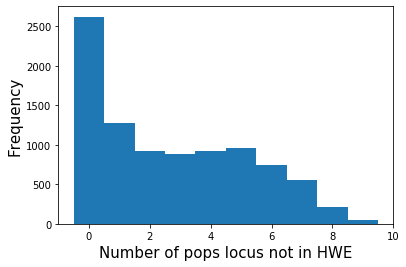

,pop_num,pop_name
0,pop_1,AukeBayAK_
1,pop_2,BellaBella
2,pop_3,Charleston
3,pop_4,ChiniakBay
4,pop_5,EldInletWA
5,pop_6,JamesIslan
6,pop_7,KeyportWA_
7,pop_8,SekiuWA_9
8,pop_9,YakutatBay


In [11]:
plt.hist(sig_counts, bins = np.arange(0,num_pops+2,1)-0.5)
plt.ylabel("Frequency", size = 15)
plt.xlabel("Number of pops locus not in HWE", size = 15)
plt.show()

popkey = pd.DataFrame(list(zip(["pop_" + str(x + 1) for x in range(num_pops)], popnames)), columns = ['pop_num', 'pop_name'])
popkey

#### **[4]** Get Q values with FDR correction

In [12]:
# make a df to store qvalues, using locus names from pvals df
HWE_qvals_df = HWE_pvals_df[['locus_name']].copy()

popnums = ["pop_" + str(x + 1) for x in range(num_pops)]
for pop in popnums:
    # sort HWE pvals df by increasing pvals in column for this pop
    all_sorted_thispop_pvals_df = HWE_pvals_df.sort_values(pop).reset_index(drop = True)
    # get index of first NaN in this column
    first_nan_index = pd.Index(list(all_sorted_thispop_pvals_df[pop])).get_loc(np.NaN)[0]
    # subset dataframe for just locus names and rows with non-Nan values
    thispop_df = all_sorted_thispop_pvals_df.iloc[0:first_nan_index-1,[0,popnums.index(pop)+1]]
    # run fdr correction test
    qvals = multitest.fdrcorrection(pvals = thispop_df[pop])[1]
    thispop_qvals_df = pd.DataFrame({'locus_name': thispop_df['locus_name'], pop: qvals})
    # merge results into qvals df
    HWE_qvals_df = pd.merge(HWE_qvals_df, thispop_qvals_df, how = "outer")
    
# write HWE qvals df to file
HWE_pvals_df.to_csv(corename + "_HWE_qvals.csv")

# look at HWE qvals array
HWE_qvals_df.head()

,locus_name,pop_1,pop_2,pop_3,pop_4,pop_5,pop_6,pop_7,pop_8,pop_9
0,JXUT01106070.1_4760,NaN,0.291960,0.032436,NaN,NaN,NaN,NaN,1.000000,1.0
1,JXUT01106070.1_4890,NaN,0.293640,0.032765,NaN,1.000000,1.000000,1.0,1.000000,1.0
2,JXUT01121266.1_26809,NaN,0.426642,0.448110,0.580789,0.286752,0.195696,1.0,1.000000,1.0
3,JXUT01121266.1_26861,0.591179,0.537797,1.000000,1.000000,1.000000,1.000000,1.0,0.619548,1.0
4,JXUT01124726.1_31535,NaN,0.298838,0.269708,0.305734,1.000000,0.033838,1.0,0.063818,NaN


#### **[5]** Write output files with loci to keep and lose based on HWE filtering threshold

In [13]:
# fn for filtering a locus based on HWE
def filter_HWE_fdr(row, xpops = xpops, alpha = alpha):
    count = 0
    indeces = [x for x in range(2, len(popnums)+2)]
    for x in indeces:
        value = row[x]
        if np.isnan(value) == False:
            if value <= alpha:
                count += 1
    if count >= xpops:
        return True
    else:
        return False

# identify loci to lose, keep based on HWE filter
loci_to_keep = []
loci_to_lose = []
for row in HWE_qvals_df.itertuples():
    if filter_HWE_fdr(row = row, alpha = alpha, xpops = xpops):
        loci_to_lose.append(row[1])
    else:
        loci_to_keep.append(row[1])
        
# write loci lists to file
HWE_lose_outfile = open(corename + "_HWE_loci_to_lose.txt", "w")
for locus in loci_to_lose:
    HWE_lose_outfile.write(locus + "\n")
HWE_lose_outfile.close()
HWE_keep_outfile = open(corename + "_HWE_loci_to_keep.txt", "w")
for locus in loci_to_keep:
    HWE_keep_outfile.write(locus + "\n")
HWE_keep_outfile.close()

        
print(len(loci_to_lose), " out of HWE")
print(len(loci_to_keep), " in HWE")

print("\nOutput file names: ")
print(corename+"_HWE_loci_to_keep.txt")
print(corename+"_HWE_loci_to_lose.txt")

4090  out of HWE
5043  in HWE

Output file names: 
primSNPs_noINDL_parcal_mox001_md70_maf05_minQ20_mDP10_inames_noreps_HWE_loci_to_keep.txt
primSNPs_noINDL_parcal_mox001_md70_maf05_minQ20_mDP10_inames_noreps_HWE_loci_to_lose.txt


In [17]:
cd ../../mnt/hgfs/E/dDocent_for_mox/parcal_wd/parcal_mox001/

/mnt/hgfs/E/dDocent_for_mox/parcal_wd/parcal_mox001


In [19]:
ls *.txt

cmdline.txt*
primSNPs_noINDL_parcal_mox001_md70_maf05_minQ20_mDP10_inames_noreps_HWE_loci_to_keep.txt*
primSNPs_noINDL_parcal_mox001_md70_maf05_minQ20_mDP10_inames_noreps_HWE_loci_to_lose.txt*
primSNPs_noINDL_parcal_mox001_md70_maf05_minQ20_mDP10_inames_noreps_HWE_out.txt*
primSNPs_noINDL_parcal_mox001_md70_maf05_minQ20_mDP10_inames_noreps.txt*
primSNPs_noINDL_parcal_mox001_md70_maf05_minQ20_mDP10_inames.txt*
primSNPs_noINDL_parcal_mox001_md70_maf05_minQ20_mDP10.txt*


In [21]:
! python subset_GP_forloci.py -h

usage: subset_GP_forloci.py [-h] -i INFILE -f FORMAT -l LOCI -o OUTFILE

Filter Genepop file to include only provided locus names.

optional arguments:
  -h, --help            show this help message and exit
  -i INFILE, --infile INFILE
                        input Genepop file for filtering
  -f FORMAT, --format FORMAT
                        input Genepop header format, answer 1 if locus names
                        are each on a line and 2 if locus names are in one
                        line separated by commas
  -l LOCI, --loci LOCI  text file of loci to keep, with each locus name on its
                        own line
  -o OUTFILE, --outfile OUTFILE
                        filtered Genepop file


In [23]:
!python subset_GP_forloci.py \
-i primSNPs_noINDL_parcal_mox001_md70_maf05_minQ20_mDP10_inames_noreps.txt \
-f 1 \
-l primSNPs_noINDL_parcal_mox001_md70_maf05_minQ20_mDP10_inames_noreps_HWE_loci_to_keep.txt \
-o primSNPs_noINDL_parcal_mox001_md70_maf05_minQ20_mDP10_inames_noreps_HWE.gen

![fis](Fis_bypop_afterHWE_20190723.png)